Circuito QFT de 4 qubits:


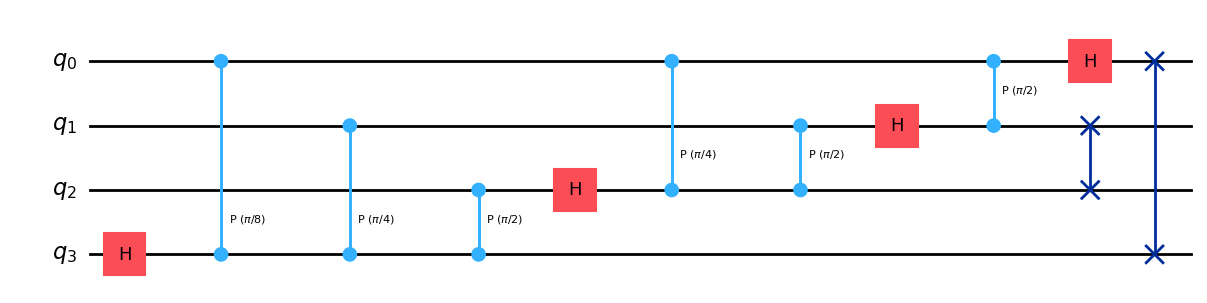


Circuito de Estimación de Fase (para theta=1/3):


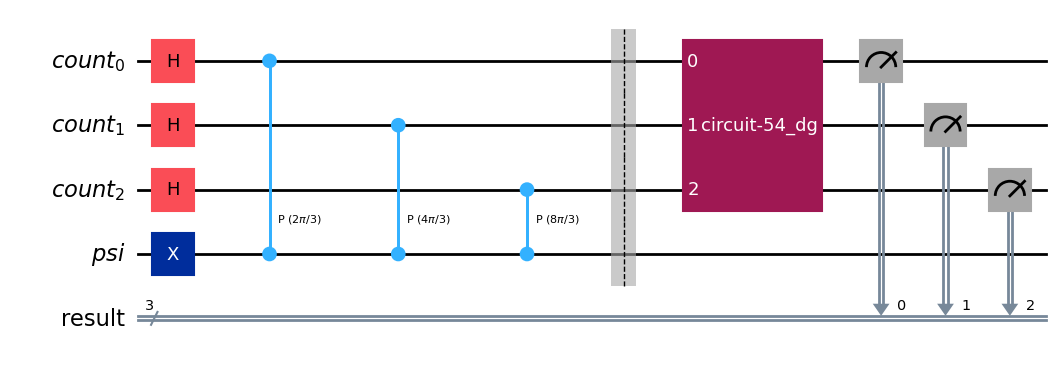

Resultados (cuentas binarias): {'001': 35, '011': 711, '100': 38, '101': 16, '010': 171, '110': 24, '000': 14, '111': 15}
Fase estimada: 0.375 (Esperado: 0.3333)

Circuito de Shor para a=7, N=15:
Resultados brutos (fases medidas): {'11000000': 277, '10000000': 244, '00000000': 235, '01000000': 268}

Análisis de resultados para N=15, a=7:
Fase Medida     | Fracción (s/r)  | Posible r 
---------------------------------------------
0.7500          | 3/4             | 4         
0.5000          | 1/2             | 2         
0.0000          | 0/1             | 1         
0.2500          | 1/4             | 4         


In [2]:
# %% [markdown]
# # Lección 7: Estimación de Fase y Factorización
# Este notebook implementa los componentes fundamentales para el algoritmo de Shor, basándose en la Estimación de Fase Cuántica (QPE).
#
# ## Contenido:
# 1. Transformada Cuántica de Fourier (QFT)
# 2. Algoritmo de Estimación de Fase (QPE) genérico
# 3. Búsqueda de Orden (El corazón del algoritmo de Shor)

# %%
# 1. Importaciones
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile # <--- Agregado transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from fractions import Fraction
import math

# Simulador
sim = AerSimulator()

# %% [markdown]
# ## 1. Transformada Cuántica de Fourier (QFT)
# La QFT es el análogo cuántico de la transformada discreta de Fourier. Es esencial para extraer la información de la fase en la base de medición.
#
# **Referencia:** Diapositivas 16-22.
# La implementación recursiva utiliza compuertas Hadamard y rotaciones de fase controladas ($CP(\theta)$).

# %%
def qft_rotations(circuit, n):
    """Realiza las rotaciones de la QFT en los primeros n qubits."""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        # Aplicar rotación controlada CP(pi / 2^(n-qubit))
        # Nota: En las diapositivas (pág. 21), las rotaciones son R_k = 2pi/2^k.
        # Aquí usamos la convención de Qiskit CP(theta).
        circuit.cp(np.pi / 2**(n - qubit), qubit, n)
    # Llamada recursiva
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    """Invierte el orden de los qubits (necesario al final de la QFT)."""
    for qubit in range(n // 2):
        circuit.swap(qubit, n - qubit - 1)
    return circuit

def qft(circuit, n):
    """Añade la QFT a los primeros n qubits del circuito."""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def inverse_qft(circuit, n):
    """
    Implementa la QFT Inversa (QFT†).
    Qiskit permite invertir circuitos fácilmente, pero teóricamente es aplicar
    las compuertas en orden inverso y con ángulos negativos.
    """
    qft_circ = QuantumCircuit(n)
    qft(qft_circ, n)
    inv_qft_circ = qft_circ.inverse()
    circuit.append(inv_qft_circ, range(n))
    return circuit

# Visualización de una QFT de 4 qubits
qc_qft = QuantumCircuit(4)
qft(qc_qft, 4)
print("Circuito QFT de 4 qubits:")
display(qc_qft.draw(output="mpl"))

# %% [markdown]
# ## 2. Estimación de Fase Cuántica (QPE)
# **Objetivo:** Dado un operador unitario $U$ y un autovector $|\psi\rangle$ tal que $U|\psi\rangle = e^{2\pi i \theta}|\psi\rangle$, estimar $\theta$.
#
# **Referencia:** Diapositivas 4-15 y 23-24.
# El circuito consta de:
# 1. Un registro de conteo en superposición (Hadamard).
# 2. Operaciones unitarias controladas $CU^{2^j}$.
# 3. La QFT inversa en el registro de conteo.

# %%
def phase_estimation_example():
    """
    Ejemplo simple de QPE.
    Usaremos la compuerta P(theta) como nuestro operador U.
    El estado |1> es un autovector de P(theta) con autovalor e^(i*theta).
    Aquí theta = 2*pi*(1/3), queremos estimar 1/3.
    """
    t = 3  # Número de qubits de conteo (precisión)
    
    # Registros
    qr_count = QuantumRegister(t, 'count')
    qr_psi = QuantumRegister(1, 'psi') # Qubit donde aplicamos U
    cr = ClassicalRegister(t, 'result')
    qc = QuantumCircuit(qr_count, qr_psi, cr)
    
    # 1. Inicialización
    # El registro de conteo inicia en |0...0>, aplicamos H a todo.
    qc.h(qr_count)
    
    # El autovector |psi> debe ser |1> para la compuerta P
    qc.x(qr_psi)
    
    # 2. Operaciones Controladas U^(2^j)
    # U = P(2pi * phase). Repetir P es equivalente a multiplicar el ángulo.
    # U^(2^j) = P(2pi * phase * 2^j)
    
    fase_real = 1/3 # Queremos que el algoritmo encuentre este valor
    angle = 2 * np.pi * fase_real
    
    for i in range(t):
        # El qubit de control es i
        # El ángulo se multiplica por 2^i
        repetitions = 2**i
        qc.cp(angle * repetitions, qr_count[i], qr_psi[0])
        
    qc.barrier()
    
    # 3. QFT Inversa en el registro de conteo
    inverse_qft(qc, t)
    
    # 4. Medición
    qc.measure(qr_count, cr)
    
    return qc

# Ejecución
qc_qpe = phase_estimation_example()
print("\nCircuito de Estimación de Fase (para theta=1/3):")
display(qc_qpe.draw(output="mpl"))

# --- MODIFICACIÓN: Transpilación ---
qc_qpe_transpiled = transpile(qc_qpe, sim)
result = sim.run(qc_qpe_transpiled, shots=1024).result()
# -----------------------------------

counts = result.get_counts()
print(f"Resultados (cuentas binarias): {counts}")

# Interpretación:
# Convertimos la cadena binaria a entero y dividimos por 2^t
measured_int = int(max(counts, key=counts.get), 2)
estimated_phase = measured_int / (2**3)
print(f"Fase estimada: {estimated_phase} (Esperado: {1/3:.4f})")

# %% [markdown]
# ## 3. Búsqueda de Orden (Shor)
# El problema central de Shor es encontrar el orden $r$ tal que $a^r \equiv 1 \pmod N$.
# Esto se reduce a QPE usando el operador unitario $M_a|x\rangle = |ax \pmod N\rangle$.
#
# **Referencia:** Diapositivas 30-40.
#
# Implementaremos un ejemplo pequeño: $N=15, a=7$.
# Sabemos que las potencias de 7 mod 15 son: 7, 4, 13, 1... (Periodo r=4).

# %%
def c_amod15(a, power):
    """
    Crea una compuerta controlada U^(2^power) para a mod 15.
    Esto es específico para N=15 y implementado 'hardcoded' para demostración,
    ya que implementar aritmética modular general en circuito es muy complejo.
    """
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' debe ser coprimo con 15")
        
    U = QuantumCircuit(4)        
    for _iteration in range(power):
        if a == 2:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a == 7:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
            U.x(0)
            U.x(1)
            U.x(2)
            U.x(3)
        if a == 8:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a == 11: 
            U.swap(2,0)
            U.swap(0,1)
            U.x(0)
            U.x(1)
            U.x(2)
        if a == 13:
            U.swap(2,0)
            U.swap(0,1)
            U.x(0)
            U.x(1)
            U.x(2)
            
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

def shor_order_finding_circuit(n_count, a=7):
    """
    Circuito de Shor para N=15.
    n_count: número de qubits de precisión.
    """
    # 4 qubits para el estado (ya que 15 necesita 4 bits: 1111)
    n_target = 4
    
    qr_n = QuantumRegister(n_count, 'counting')
    qr_target = QuantumRegister(n_target, 'target')
    cr = ClassicalRegister(n_count, 'result')
    qc = QuantumCircuit(qr_n, qr_target, cr)
    
    # 1. Inicialización
    qc.h(qr_n) # Superposición en conteo
    qc.x(qr_target[0]) # Estado inicial |1> (eigenvector superposición)
    
    # 2. Aplicar U controlados modulares
    for q in range(n_count):
        # Aplicamos a^(2^q) mod 15 controlado por el qubit q
        qc.append(c_amod15(a, 2**q), 
                 [qr_n[q]] + [qr_target[i] for i in range(n_target)])
        
    # 3. QFT Inversa en conteo
    inverse_qft(qc, n_count)
    
    # 4. Medición
    qc.measure(qr_n, cr)
    
    return qc

# Configuración del experimento
N = 15
a = 7
n_count = 8 # Qubits de precisión (slide 36 sugiere 2*lg(N) + 1 approx)

qc_shor = shor_order_finding_circuit(n_count, a)
print(f"\nCircuito de Shor para a={a}, N={N}:")
# display(qc_shor.draw(output="mpl")) # Puede ser muy grande

# --- MODIFICACIÓN: Transpilación ---
qc_shor_transpiled = transpile(qc_shor, sim)
counts = sim.run(qc_shor_transpiled, shots=1024).result().get_counts()
# -----------------------------------

print(f"Resultados brutos (fases medidas): {counts}")
plot_histogram(counts)

# %% [markdown]
# ## 4. Post-procesamiento Clásico (Fracciones Continuas)
# Una vez obtenida la fase medida $\phi \approx s/r$, usamos el algoritmo de fracciones continuas para encontrar $r$.
# **Referencia:** Diapositiva 36.

# %%
print(f"\nAnálisis de resultados para N={N}, a={a}:")

measured_phases = []
for output in counts:
    decimal = int(output, 2)
    phase = decimal / (2**n_count)
    measured_phases.append(phase)

rows = []
for phase in measured_phases:
    # Usamos Fraction para encontrar la fracción irreducible más cercana
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    s = frac.numerator
    rows.append([phase, f"{s}/{r}", r])

print(f"{'Fase Medida':<15} | {'Fracción (s/r)':<15} | {'Posible r':<10}")
print("-" * 45)
for row in rows:
    print(f"{row[0]:<15.4f} | {row[1]:<15} | {row[2]:<10}")

# El valor correcto de r para a=7, N=15 es 4.
# Deberías ver '4' (o múltiplos/factores que lleven a 4) en la columna 'Posible r'.